# Data Science Final Project
Charles Laurent, Jenny Park, AJ Marino

## Part 1a - Random Forest Regressor - FULL DATA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import metrics
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

pd.set_option('display.max_columns', None)

In [3]:
# TODO - Update path to files
datadir='../dev/project/CollegeScorecard_Raw_Data'

# TODO set features_dir 
features_dir = './data'


In [4]:
# import collegedatalib
import collegedatahelper

In [5]:
%%time
data_dict = collegedatahelper.create_data_dict_full(datadir)

CPU times: user 3min 12s, sys: 26 s, total: 3min 38s
Wall time: 3min 39s


## Adding GDP (External Data)

In [37]:
gdp_df = pd.read_csv(f'{features_dir}/gdp.csv', low_memory=False)

In [38]:
gdp_df['year'] = gdp_df['year'].apply(str)


In [55]:
gdp_df.head()

,year,GDP
0,2018,20500.6
1,2017,19485.4
2,2016,18707.2
3,2015,18219.3
4,2014,17521.7


In [41]:
%%time

dictionary = data_dict.copy()
full_df = pd.DataFrame()

for year in data_dict:
    dictionary[year]['year'] = year[:4]
    full_df = full_df.append(dictionary[year], sort=False)

# Add GDP data to full dataframe
full_df = full_df.merge(gdp_df, left_on='year', right_on='year')


CPU times: user 1min 1s, sys: 44.2 s, total: 1min 46s
Wall time: 1min 14s


In [42]:
def format_df(df):
    df_copy = df.copy()

    # Drop all columns with less than 95% not nan
    rows = df_copy.shape[0]
    df_copy = df_copy.apply(pd.to_numeric, errors='coerce')
    df_copy = df_copy.dropna(axis=1, thresh=rows*0.9)

    # Add back debt_to_income
    df_copy['debt_to_income'] = df['debt_to_income']

    # Drop all rows with nan
    df_copy = df_copy.dropna(axis=0)
    
    return df_copy

In [43]:
%%time
# CONTROL 
# 1 - Public
# 2 - Private non-profit
# 3 - Private for-profit
df_pub = format_df(full_df.loc[full_df['CONTROL'] == 1])
df_priv = format_df(full_df.loc[full_df['CONTROL'] == 2])
df_priv_profit = format_df(full_df.loc[full_df['CONTROL'] == 3])

CPU times: user 33.1 s, sys: 18.8 s, total: 51.9 s
Wall time: 48.3 s


In [44]:
df_pub.shape

(12649, 248)

In [45]:
df_priv.shape

(10696, 204)

In [46]:
df_priv_profit.shape

(17447, 247)

## Random Forest

In [47]:
def fitRandomForestRegressor(df, train_features, target='debt_to_income'):
    # Instantiate model with 10 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score=True)

    rf.fit(df[train_features], df['debt_to_income'])
    
    return rf


In [48]:
def getImportantFeatures(rf, df):
    important_features_dict = {}
    for x,i in enumerate(rf.feature_importances_):
        important_features_dict[x]=i


    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)
    
    top_features = df.columns[important_features_list]
    
    return top_features[:20]

In [49]:
%%time
df_pub_copy = format_df(df_pub)

# Split train data
df_pub_train = df_pub_copy.dropna(subset=['debt_to_income'])

print('Important Features for Public Colleges/Universities: ')
train_features_pub = list(df_pub_train.columns)
train_features_pub.remove('debt_to_income')
train_features_pub.remove('UNITID')
train_features_pub.remove('year')

rf_pub = fitRandomForestRegressor(df_pub_train, train_features_pub)
top_features_pub = getImportantFeatures(rf_pub, df_pub_train)
print(top_features_pub)

Important Features for Public Colleges/Universities: 
Index(['UGDS_WOMEN', 'NUMBRANCH', 'UGDS_UNKN', 'PREDDEG', 'PPTUG_EF',
       'ST_FIPS', 'CIP54BACHL', 'CONTROL', 'PCIP49', 'UGDS_MEN', 'OPEID6',
       'MAIN', 'PCIP50', 'ICLEVEL', 'UNITID', 'PCIP42', 'PCIP43', 'OPEID',
       'UGDS_NRA', 'UGDS'],
      dtype='object')
CPU times: user 49.1 s, sys: 558 ms, total: 49.6 s
Wall time: 49.5 s


In [50]:
%%time
df_priv_copy = format_df(df_priv)

# Split train data
df_priv_train = df_priv_copy.dropna(subset=['debt_to_income'])

print('Important Features for Private Colleges/Universities: ')
train_features_priv = list(df_priv_train.columns)
train_features_priv.remove('debt_to_income')
train_features_priv.remove('UNITID')
train_features_priv.remove('year')

rf_priv = fitRandomForestRegressor(df_priv_train, train_features_priv)
top_features_priv = getImportantFeatures(rf_priv, df_priv_train)
print(top_features_priv)

Important Features for Private Colleges/Universities: 
Index(['ICLEVEL', 'CIP50CERT4', 'UNITID', 'OPEID', 'CIP52CERT4', 'CONTROL',
       'ST_FIPS', 'CIP45CERT4', 'NUMBRANCH', 'PREDDEG', 'CIP04CERT4', 'MAIN',
       'CIP51CERT2', 'CIP13CERT4', 'CIP52CERT2', 'CIP51CERT4', 'CIP14CERT4',
       'CIP24CERT4', 'CIP11CERT4', 'CIP39CERT4'],
      dtype='object')
CPU times: user 15.1 s, sys: 263 ms, total: 15.3 s
Wall time: 14.8 s


In [51]:
%%time
df_priv_profit_copy = format_df(df_priv_profit)

# Split train data
df_priv_profit_train = df_priv_profit_copy.dropna(subset=['debt_to_income'])

print('Important Features for Private for Profit Colleges/Universities: ')
train_features_priv_profit = list(df_priv_profit_train.columns)
train_features_priv_profit.remove('debt_to_income')
train_features_priv_profit.remove('UNITID')
train_features_priv_profit.remove('year')

rf_priv_profit = fitRandomForestRegressor(df_priv_profit_train, train_features_priv_profit)
top_features_priv_profit = getImportantFeatures(rf_priv_profit, df_priv_profit_train)
print(top_features_priv_profit)

Important Features for Private for Profit Colleges/Universities: 
Index(['UGDS_WOMEN', 'MAIN', 'CIP54BACHL', 'OPEID', 'CONTROL', 'UNITID',
       'ICLEVEL', 'UGDS_MEN', 'ST_FIPS', 'UGDS_UNKN', 'UGDS_NRA', 'PCIP49',
       'PCIP50', 'PCIP11', 'NUMBRANCH', 'PCIP51', 'PREDDEG', 'CIP12ASSOC',
       'UGDS', 'PCIP10'],
      dtype='object')
CPU times: user 30.8 s, sys: 349 ms, total: 31.2 s
Wall time: 30.5 s


In [52]:
print(rf_pub.oob_score_)
print(rf_priv.oob_score_)
print(rf_priv_profit.oob_score_)


0.8779168361580462
0.8097776710213376
0.7780432641595247


## Predicting NYU Debt-to-Income

In [53]:
df_nyu = full_df.loc[full_df['UNITID'] == 193900]

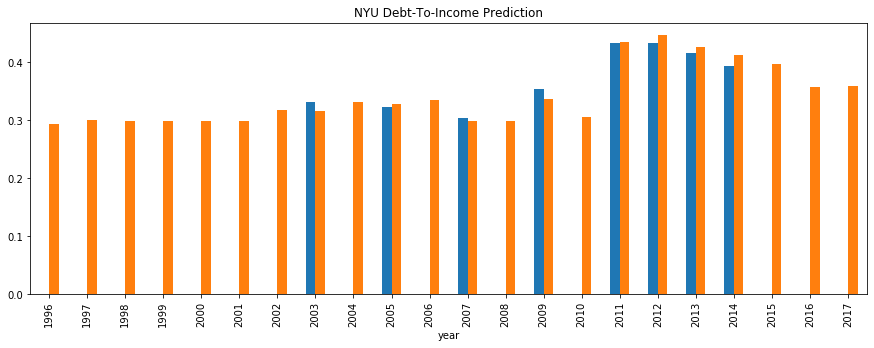

In [54]:
predictions = rf_priv.predict(df_nyu[train_features_priv])

nyu_data = {
    'year': list(df_nyu['year']),
    'debt_to_income': list(df_nyu['debt_to_income']),
    'prediction': list(predictions)
}

df_nyu = pd.DataFrame(nyu_data)

ax = df_nyu.plot.bar(
    x='year',
    title='NYU Debt-To-Income Prediction',
    legend=False,
    figsize=(15,5)
)